In [2]:
import numpy as np
import anndata
import pandas as pd
import os
from src import preprocess, get_hg_reduction, reduce, scatterplot, knn_auto, run_classical_methods
import matplotlib.pyplot as plt
import igraph as ig
import leidenalg as la
import seaborn as sns
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
import itertools
from datetime import datetime

/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Run Methods on Datasets

In [3]:
# Identify cell type columns in each dataset
DATA_LOG = []
resolutions = [i/10 for i in range(5,16)]
CT_COLS = {
    'darmanis_brain.h5ad': 'cell.type',
    'romanov_brain.h5ad': 'labels',
    'zhong_prefrontal.h5ad': 'cell_types',
    'lawlow_pancreas.h5ad': 'cell type',
    'hermann_spermatogenesis.h5ad': 'celltype',
    'ReprocessedAllenData.h5ad': 'Primary.Type',
}

## Run classical methods from class

In [5]:
datasets = list(CT_COLS.keys())
n_clusters = list(range(2, 20))
trials = list(range(5))
combos = itertools.product(datasets, n_clusters, trials)

In [ ]:
i = 0
last_time = datetime.now()
for dataset in datasets:

    if (
        (dataset in DATA_LOG and len(DATA_LOG[dataset]) == len(resolutions) ** 2)
        or (not dataset.endswith('.h5ad'))
    ):
        continue
        
    print(f"Running {dataset}")
    
    dataset_fn = os.path.join("data", dataset)

    # Read in data
    adata = anndata.read_h5ad(dataset_fn)
    adata = preprocess(
        adata,
        filter_genes=True,
        normalize=True,
        log1p=True,
        high_var=True,
        scale=True,
    )
    
    # Add cell type to 'labels'
    adata.obs['labels'] = adata.obs[CT_COLS[dataset]]
    
    for c in range(2, 21):
        print(c, datetime.now() - last_time)
        last_time = datetime.now()
        ground_truth = np.unique(adata.obs["labels"], return_inverse=True)[1]
        kmeans = KMeans(n_clusters=c, random_state=i).fit(adata.X)
        score_kmeans = silhouette_score(adata.X, kmeans.labels_)
        DATA_LOG.append(
            {
                "dataset": dataset,
                "silhouette_score": score_kmeans,
                "num_clusters": c,
                "method": "kmeans",
                "trial": i,
                "labels": kmeans.labels_,
                "ground_truth": ground_truth,
            }
        )
        clustering = SpectralClustering(
            n_clusters=c, random_state=i, affinity="nearest_neighbors"
        ).fit(adata.X)
        score_spectral = silhouette_score(adata.X, clustering.labels_)
        DATA_LOG.append(
            {
                "dataset": dataset,
                "silhouette_score": score_spectral,
                "num_clusters": c,
                "method": "spectral",
                "trial": i,
                "labels": clustering.labels_,
                "ground_truth": ground_truth,
            }
        )

        gm = GaussianMixture(n_components=c, random_state=i).fit(adata.X)
        labels_gm = gm.predict(adata.X)
        score_gm = silhouette_score(adata.X, labels_gm)
        DATA_LOG.append(
            {
                "dataset": dataset,
                "silhouette_score": score_gm,
                "num_clusters": c,
                "method": "gm",
                "trial": i,
                "labels": labels_gm,
                "ground_truth": ground_truth,
            }
        )

## Get number of clusters selected by Leiden

In [188]:
CLUSTERS = []
for dataset in os.listdir("data"):

    if (
        (dataset in DATA_LOG and len(DATA_LOG[dataset]) == len(resolutions) ** 2)
        or (not dataset.endswith('.h5ad'))
    ):
        continue
        
    print(f"Running {dataset}")
    
    dataset_fn = os.path.join("data", dataset)

    # Read in data
    adata = anndata.read_h5ad(dataset_fn)
    adata = preprocess(
        adata,
        filter_genes=True,
        normalize=True,
        log1p=True,
        high_var=True,
        scale=True,
    )
    
    # Add cell type to 'labels'
    adata.obs['labels'] = adata.obs[CT_COLS[dataset]]

    # this is sparse
    reduced_adj = get_hg_reduction(adata.X, n_clusters=4)
    print(f"Adjacency matrix has shape {reduced_adj.shape}")
    order = np.argsort(adata.obs['labels']) # cells ordered so we can see blocks in the heatmap

    # Construct graph using reduced adj
    sources, targets = reduced_adj.nonzero()
    weights = np.array(reduced_adj[sources, targets])
    gg = ig.Graph(directed=False)
    gg.add_vertices(adata.shape[0]) # cells
    gg.add_edges(list(zip(list(sources), list(targets))))

    # Construct graph with KNN
    sources_base, targets_base, weights_base = knn_auto(adata.X)
    gg_base = ig.Graph(directed=False)
    gg_base.add_vertices(adata.shape[0]) # cells
    gg_base.add_edges(list(zip(list(sources_base), list(targets_base))))
    
    res = 1

    ## Run Leiden - Reduced Adj
    part = la.find_partition(
        gg,
        la.RBConfigurationVertexPartition,
        weights=weights.flatten(),
        resolution_parameter=res,
    )
    predictions_reduced_hg = np.array(part.membership, dtype=int)
    score_reduced = ARI(predictions_reduced_hg, adata.obs['labels'])

    CLUSTERS.append({
        'dataset': dataset,
        'score': score_reduced,
        'method': 'reduced',
        'num_clusters': len(np.unique(predictions_reduced_hg)),
    })

    ## Run Leiden - KNN
    part_base = la.find_partition(
        gg_base,
        la.RBConfigurationVertexPartition,
        resolution_parameter=res,
    )
    predictions_base = np.array(part_base.membership, dtype=int)
    score_base = ARI(predictions_base, adata.obs['labels'])

    CLUSTERS.append({
        'dataset': dataset,
        'score': score_base,
        'method': 'base',
        'num_clusters': len(np.unique(predictions_base)),
    })
    
    CLUSTERS.append({
        'dataset': dataset,
        'score': score_base,
        'method': 'ground_truth',
        'num_clusters': len(np.unique(adata.obs['labels'])),
    })

Running darmanis_brain.h5ad
adata has shape (466, 22085)
After preprocessing, adata has shape (466, 5683)


100%|██████████████████████████████████████████████████████████████████| 5683/5683 [02:45<00:00, 34.31it/s]


Adjacency matrix has shape (466, 466)
Running romanov_brain.h5ad
adata has shape (2881, 24341)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (2881, 3729)


100%|██████████████████████████████████████████████████████████████████| 3729/3729 [04:12<00:00, 14.75it/s]


Adjacency matrix has shape (2881, 2881)
Running zhong_prefrontal.h5ad
adata has shape (2394, 24153)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (2394, 3976)


100%|██████████████████████████████████████████████████████████████████| 3976/3976 [04:34<00:00, 14.49it/s]
/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Adjacency matrix has shape (2394, 2394)
Running lawlow_pancreas.h5ad
adata has shape (638, 26616)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (638, 6382)


100%|██████████████████████████████████████████████████████████████████| 6382/6382 [03:29<00:00, 30.41it/s]


Adjacency matrix has shape (638, 638)
Running ReprocessedAllenData.h5ad
adata has shape (379, 20816)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (379, 4645)


100%|██████████████████████████████████████████████████████████████████| 4645/4645 [02:20<00:00, 33.05it/s]


Adjacency matrix has shape (379, 379)
Running hermann_spermatogenesis.h5ad
adata has shape (2325, 54448)


/Users/mike/opt/miniconda3/envs/leiden2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing, adata has shape (2325, 3822)


100%|██████████████████████████████████████████████████████████████████| 3822/3822 [03:36<00:00, 17.68it/s]


Adjacency matrix has shape (2325, 2325)


In [259]:
len(DATA_LOG)

900

In [273]:
df = pd.DataFrame(DATA_LOG)
df.to_csv('output/classical_methods_raw.csv', index=False)
df.head()

,dataset,score,num_clusters,method,trial
0,darmanis_brain.h5ad,0.384034,10,spectral,0
1,darmanis_brain.h5ad,0.637491,10,kmeans,0
2,darmanis_brain.h5ad,0.106815,10,gm,0
3,darmanis_brain.h5ad,0.421960,11,spectral,0
4,darmanis_brain.h5ad,0.590129,11,kmeans,0


In [ ]:
# Write experimental data
leiden_cluster_df = pd.DataFrame(CLUSTERS)
leiden_cluster_df.to_csv('output/leiden_cluster_data.csv', index=False)

In [47]:
df = pd.DataFrame(DATA_LOG)
df.to_csv('output/one_trial_silhouette_score.csv')

In [14]:
df.head()

,dataset,silhouette_score,num_clusters,method,trial,labels,ground_truth
0,darmanis_brain.h5ad,0.033235,2,kmeans,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[8, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 1, ..."
1,darmanis_brain.h5ad,-0.008399,2,spectral,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[8, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 1, ..."
2,darmanis_brain.h5ad,0.043289,2,gm,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[8, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 1, ..."
3,darmanis_brain.h5ad,0.047225,3,kmeans,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[8, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 1, ..."
4,darmanis_brain.h5ad,-0.009007,3,spectral,0,"[2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, ...","[8, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 1, ..."


# Data Analysis

In [4]:
# Get num_clusters with top silhouette score for each dataset
df = pd.read_csv('output/one_trial_silhouette_score.csv', index_col=0)
top_df = df.sort_values('silhouette_score').drop_duplicates(['dataset','method'], keep='last')
top_df.head()

,dataset,silhouette_score,num_clusters,method,trial,labels,ground_truth
205,ReprocessedAllenData.h5ad,-0.012918,5,spectral,0,[0 0 0 3 0 3 0 0 0 0 0 3 0 0 0 0 3 3 3 0 3 3 3...,[ 2 2 7 15 2 1 2 1 1 2 2 0 2 2 5 ...
13,darmanis_brain.h5ad,0.000425,6,spectral,0,[1 5 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0...,[8 5 8 5 5 8 8 5 5 5 8 5 5 5 1 5 5 5 8 8 8 8 0...
40,romanov_brain.h5ad,0.017452,2,spectral,0,[1 1 0 ... 0 0 0],[5 5 5 ... 4 4 4]
45,romanov_brain.h5ad,0.023149,4,kmeans,0,[2 2 0 ... 0 0 0],[5 5 5 ... 4 4 4]
118,lawlow_pancreas.h5ad,0.044791,2,spectral,0,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[6 2 2 2 6 2 7 2 2 2 4 1 1 1 2 2 1 2 1 0 1 1 6...


In [22]:
# Calculate ARI for these top number of clusters
def ARI_row(row):
    return ARI(row['labels'], row['ground_truth'])
top_df['ARI'] = top_df.apply(ARI_row, axis=1)

In [36]:
top_df.head()

,dataset,silhouette_score,num_clusters,method,trial,labels,ground_truth,ARI
205,ReprocessedAllenData.h5ad,-0.012918,5,spectral,0,"[0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...","[2, 2, 7, 15, 2, 1, 2, 1, 1, 2, 2, 0, 2, 2, 5,...",0.231805
13,darmanis_brain.h5ad,0.000425,6,spectral,0,"[1, 5, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[8, 5, 8, 5, 5, 8, 8, 5, 5, 5, 8, 5, 5, 5, 1, ...",0.449507
40,romanov_brain.h5ad,0.017452,2,spectral,0,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",0.338498
45,romanov_brain.h5ad,0.023149,4,kmeans,0,"[2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...",0.605354
118,lawlow_pancreas.h5ad,0.044791,2,spectral,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6, 2, 2, 2, 6, 2, 7, 2, 2, 2, 4, 1, 1, 1, 2, ...",0.051188


In [39]:
# Get the ARI performance from Leiden methods
leiden_df = pd.read_csv('output/leiden_data.csv')
leiden_df = leiden_df[(leiden_df['method'] == 'reduced') & (leiden_df['res'] == 1.1)]
leiden_df['ARI'] = leiden_df['mean']

## Plot 1: Compare ARI of classical methods with Leiden

In [41]:
# Get best performing ARI for each classical method and compare with Leiden
plot1_df = pd.concat([top_df, leiden_df])
plot1_df['method'] = pd.Categorical(plot1_df['method'], categories=['reduced', 'kmeans', 'gm', 'spectral'])

In [43]:
true_titles = {
    'ReprocessedAllenData.h5ad': 'Tasic et al. (2016)\n Mouse Visual Cortex',
    'darmanis_brain.h5ad': 'Darmanis et al. (2015)\n Human Brain',
    'hermann_spermatogenesis.h5ad': 'Hermann et al. (2018)\n Mouse Spermatogenic Cells',
    'lawlow_pancreas.h5ad': 'Lawlor et al. (2017)\n Human Pancreas', 
    'romanov_brain.h5ad': 'Romanov et al. (2017)\n Mouse Brain', 
    'zhong_prefrontal.h5ad': 'Zhong et al. (2018)\n Human Prefrontal Cortex', 
}

<ErrorbarContainer object of 3 artists>

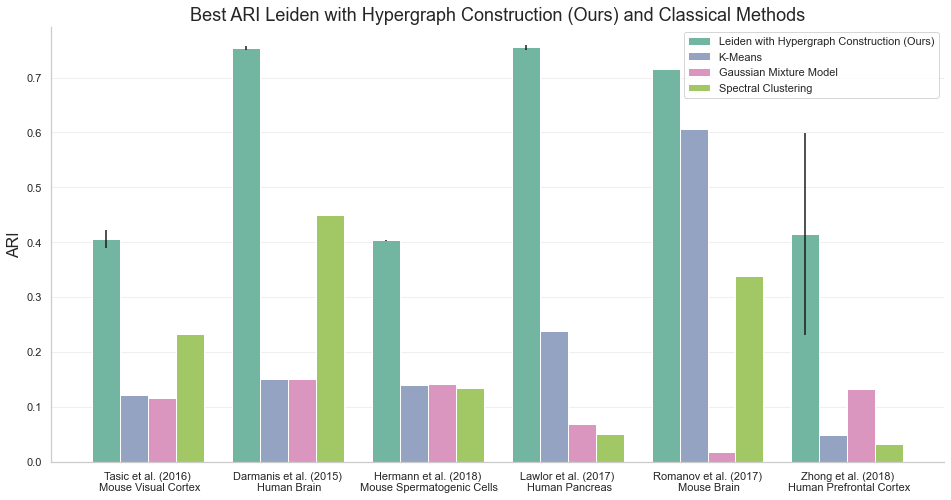

In [44]:
# Custom color palette
custom_set2 = list(sns.color_palette("Set2"))
custom_set2.pop(1)

ax = sns.barplot(
    x="dataset",
    y="ARI",
    hue="method",
    data=plot1_df.groupby(['dataset', 'method']).max().reset_index(), # enforce consistent order on datasets
    palette=custom_set2,
)
ax.set_ylabel("ARI", fontsize = 16)
ax.set_xlabel(None)
ax.set_title("Best ARI Leiden with Hypergraph Construction (Ours) and Classical Methods", fontsize=18)

handles, labels = ax.get_legend_handles_labels()
labels = ['Leiden with Hypergraph Construction (Ours)', 'K-Means', 'Gaussian Mixture Model', 'Spectral Clustering']
ax.legend(handles, labels)

ax.set_xticklabels( true_titles.values() )
plt.xticks(rotation = 0)
ax.grid(False)
ax.grid(True, which='major', axis='y', alpha=0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('output/best_ARI_classical.svg')

errors = np.array(plot1_df.groupby(['method', 'dataset']).mean()['std'])
x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=errors, fmt="none", c= "k")

## Plot 2: Compare selected no. of clusters by classical methods with Leiden

In [45]:
# Read experimental data
# Construct dataframe with number of clusters associated with highest ARI from each method
plot2_df = plot1_df[['dataset', 'method', 'num_clusters']].dropna()
leiden_cluster_df = pd.read_csv('output/leiden_cluster_data.csv')[['dataset', 'method', 'num_clusters']]
plot2_df = pd.concat([plot2_df, leiden_cluster_df])
plot2_df['method'] = pd.Categorical(
    plot2_df['method'],
    categories=['ground_truth', 'reduced', 'base', 'kmeans', 'gm', 'spectral'],
)

In [ ]:
# Custom color palette
custom_set2 = list(sns.color_palette("Set2"))
custom_set2.insert(0,custom_set2[-1])

ax = sns.barplot(
    x="dataset",
    y="num_clusters",
    hue="method",
    data=plot2_df.groupby(['dataset', 'method']).max().reset_index(), # enforce consistent order on datasets
    palette=custom_set2,
)
ax.set_ylabel("Number of Clusters", fontsize = 16)
ax.set_xlabel(None)
ax.set_title("Number of Clusters Selected by Methods", fontsize=18)

handles, labels = ax.get_legend_handles_labels()
labels = [
    'Ground Truth',
    'Leiden with Hypergraph Construction (Ours)',
    'Leiden with KNN Construction',
    'K-Means',
    'Gaussian Mixture Model',
    'Spectral Clustering',
]
ax.legend(handles, labels)

ax.set_xticklabels( true_titles.values() )
plt.xticks(rotation = 0)
ax.grid(False)
ax.grid(True, which='major', axis='y', alpha=0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('output/num_clusters.svg')